### Prédiction des survies titanic avec les réseaux de neurones
Dans ce travail, nous allons reprédire le taux de survie pendant le naufrage titanic mais maintenant en utilisant les arbres de décisions

### Packages

In [226]:
import numpy as np
import pandas as pd
import csv
import chardet
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

RANDOM_STATE = 55 ## Nous passerons ce valeur pour chaque fonction sklearn afin d'assuerer la reproductibilite

### Préparation des données

In [227]:
#Connaitre l'encodage du csv
with open('data/train.csv','rb') as file:
    rawdata = file.read(1000)
    result = chardet.detect(rawdata)
    enc = result['encoding']
#lire le csv
data = pd.read_csv('data/train.csv',encoding = enc)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Encodage one-hot en utilisant pandas

Avant d'utiliser l'encodage one-hot, nous allons d'abord supprimer les colonnes Name, Ticket et PassengerId car ces 2 colonnes ne nous aident pas a la prediction

In [228]:
#data = data.drop(columns=['Name','Ticket','PassengerId','Embarked','Fare','Cabin'])
data = data.drop(columns=['Name','Ticket','PassengerId','Fare'])

In [229]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked
0,0,3,male,22.0,1,0,NaN,S
1,1,1,female,38.0,1,0,C85,C
2,1,3,female,26.0,0,0,NaN,S
3,1,1,female,35.0,1,0,C123,S
4,0,3,male,35.0,0,0,NaN,S


Maintenant encodant notre dataset

In [230]:
cat_variables = [
    'Sex','Pclass','Cabin','Embarked'
]
#cat_variables = [
#    'Sex','Pclass'
#]

In [231]:
data_hot = pd.get_dummies(data = data,
                         prefix = cat_variables,
                         columns = cat_variables)
data_hot['Age'] = data_hot['Age'].fillna(data_hot['Age'].median())
data_hot.head()

,Survived,Age,SibSp,Parch,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Cabin_A10,...,Cabin_F G73,Cabin_F2,Cabin_F33,Cabin_F38,Cabin_F4,Cabin_G6,Cabin_T,Embarked_C,Embarked_Q,Embarked_S
0,0,22.0,1,0,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
1,1,38.0,1,0,True,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,1,26.0,0,0,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
3,1,35.0,1,0,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,0,35.0,0,0,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True


Nous remarquons ici qu'apres l'encodage one-hot, le nombre de colomne a augmenter de 159. Cela est du a la colomne Cabin. Ceci peut provoquer un surajustement.

Pour eviter cela, nous allons juste diviser en deux colomnes: s'il n'y a pas de valeurs alors on mettra false sinon on mettra true

In [232]:
resultatNa = data.query('Cabin.isna()')
resultatNonNa = data.query('Cabin.notna()')
comptageNa = resultatNa['Survived'].value_counts()
comptageNonNa = resultatNonNa['Survived'].value_counts()
print(comptageNa)
print(comptageNonNa)
resultatNa = data.query('Age.isna()')
resultatNonNa = data.query('Age.notna()')
comptageNa = resultatNa['Survived'].value_counts()
comptageNonNa = resultatNonNa['Survived'].value_counts()
print(comptageNa)
print(comptageNonNa)

Survived
0    481
1    206
Name: count, dtype: int64
Survived
1    136
0     68
Name: count, dtype: int64
Survived
0    125
1     52
Name: count, dtype: int64
Survived
0    424
1    290
Name: count, dtype: int64


In [233]:
# Utilisation de mask() pour remplacer toutes les valeurs non Nan par True
data['Cabin'] = data['Cabin'].mask(data['Cabin'].notna(),True)
#Remplacer toutes les valeurs Nan en False
data['Cabin'] = data['Cabin'].fillna(False)
data_mean = data['Age'].mean()
data['Age'] = data['Age'].fillna(data_mean)
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked
0,0,3,male,22.0,1,0,False,S
1,1,1,female,38.0,1,0,True,C
2,1,3,female,26.0,0,0,False,S
3,1,1,female,35.0,1,0,True,S
4,0,3,male,35.0,0,0,False,S


Maintenant nous pouvons recommancer l'encodage

In [234]:
cat_variables = [
    'Sex','Embarked','Pclass'
]
#cat_variables = [
#    'Sex','Pclass'
#]
data_hot = pd.get_dummies(data = data,
                         prefix = cat_variables,
                         columns = cat_variables)
data_hot.head()

,Survived,Age,SibSp,Parch,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0,22.0,1,0,False,False,True,False,False,True,False,False,True
1,1,38.0,1,0,True,True,False,True,False,False,True,False,False
2,1,26.0,0,0,False,True,False,False,False,True,False,False,True
3,1,35.0,1,0,True,True,False,False,False,True,True,False,False
4,0,35.0,0,0,False,False,True,False,False,True,False,False,True


Nous allons maintenant definir notre xTrain ou notre ensemble de donnee qu'on va utiliser pour la prediction

In [235]:
var = [x for x in data_hot.columns if x not in 'Survived'] ## Removing our target variable

In [236]:
print(len(var))

12


# 3. Splitting the Dataset

Dans cette section, nous diviserons notre ensemble de données en ensembles de données d'entraînement et de test. Nous utiliserons la fonction `train_test_split` de Scikit-learn.

In [237]:
X_train, X_test, y_train, y_test = train_test_split(data_hot[var], data_hot['Survived'], train_size = 0.8, random_state = RANDOM_STATE)

In [238]:
print(f'train samples: {len(X_train)}\ntest samples: {len(X_test)}')
print(f'target proportion: {sum(y_train)/len(y_train):.4f}')

train samples: 712
test samples: 179
target proportion: 0.3834


# 4. Construisons les modeles

## 4.1 Decision Tree
Dans cette section, travaillons avec l'arbre de décision , mais en utilisant maintenant l'[implémentation de Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). 
Les hyperparamètres que nous utiliserons et étudierons ici sont :

 - min_samples_split : Le nombre minimum d'échantillons requis pour diviser un nœud interne. Cela peut empêcher le surapprentissage.
 - max_degree : La profondeur maximale de l'arborescence. Cela peut empêcher le surapprentissage.

In [239]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700] ## Si le nombre est un nombre entier, alors c'est la quantité réelle d'échantillons,
max_depth_list = [1,2, 3, 4, 8, 16, 32, 64, None] # None signifie qu'il n'y a pas de limite de profondeur.

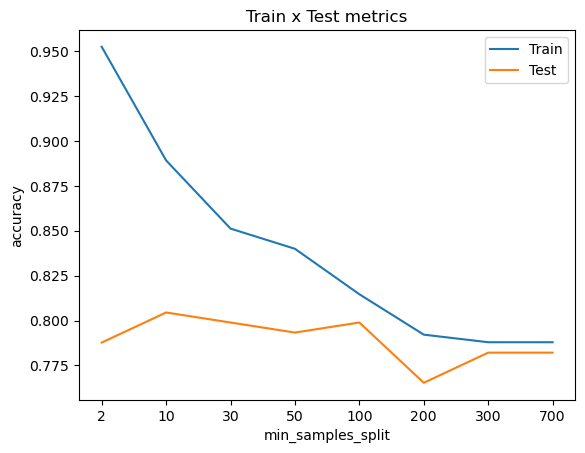

In [240]:
accuracy_list_train = []
accuracy_list_test = []
for min_samples_split in min_samples_split_list:
    # Nous pouvons ajuster le modèle en même temps que nous le définissons, car la fonction d'ajustement renvoie l'estimateur ajusté.
    model = DecisionTreeClassifier(min_samples_split = min_samples_split,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## Les valeurs prédites pour l'ensemble de données du train
    predictions_test = model.predict(X_test) ## Les valeurs prédites pour l'ensemble de données de test
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_test = accuracy_score(predictions_test,y_test)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_test.append(accuracy_test)
    
plt.title('Train x Test metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_test)
plt.legend(['Train','Test'])

Nous pouvons Noter ici que l'augmentation du nombre de « min_samples_split » diminue le surajustement. 

Faisons la même expérience avec `max_degree`.

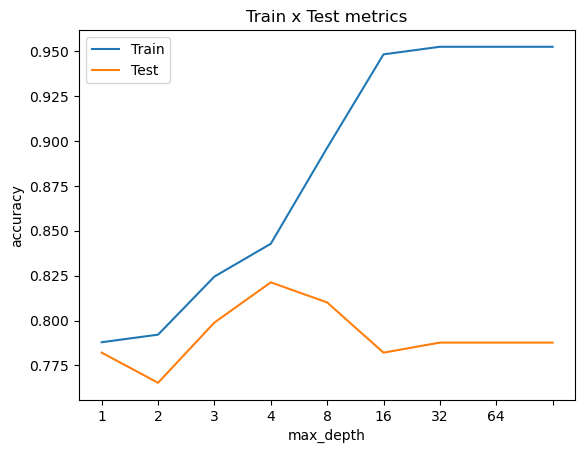

In [241]:
accuracy_list_train = []
accuracy_list_test = []
for max_depth in max_depth_list:
    model = DecisionTreeClassifier(max_depth = max_depth,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train)
    predictions_test = model.predict(X_test)
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_test = accuracy_score(predictions_test,y_test)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_test.append(accuracy_test)

plt.title('Train x Test metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_test)
plt.legend(['Train','Test'])

En analysant bien les 2 graphiques, voic les hyperparametres qui correspandent bien a nos donnees
- `max_profondeur = 3`
- `min_samples_split = 300`

In [242]:
decision_tree_model = DecisionTreeClassifier(min_samples_split = 100,
                                             max_depth = 4,
                                             random_state = RANDOM_STATE).fit(X_train,y_train)

In [243]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_test),y_test):.4f}")

Metrics train:
	Accuracy score: 0.8146
Metrics test:
	Accuracy score: 0.7989


Aucun signe de surajustement, même si les mesures ne sont pas très bonnes.

## 4.2 Random Forest

Essayons maintenant également l'algorithme Random Forest, en utilisant l'implémentation Scikit-learn. Naturellement, tous les hyperparamètres ci-dessus existeront dans cet algorithme, puisqu'il ne s'agit que d'un ensemble d'arbres de décision, mais auront un autre hyperparamètre que nous utiliserons, appelé « n_estimators », qui correspond au nombre d'arbres de décision différents qui seront ajustés. 

Nous exécuterons à nouveau le même script, mais avec un autre paramètre, `n_estimators`, où nous choisirons entre 10, 50 et 100. La valeur par défaut est 100.

In [244]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700]
max_depth_list = [2, 4, 8, 16, 32, 64, None]
n_estimators_list = [10,50,100,500]

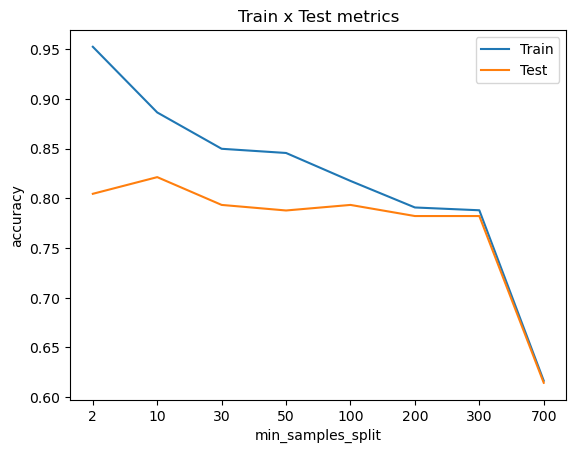

In [245]:
accuracy_list_train = []
accuracy_list_test = []
for min_samples_split in min_samples_split_list:
    model = RandomForestClassifier(min_samples_split = min_samples_split,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train)
    predictions_test = model.predict(X_test)
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_test = accuracy_score(predictions_test,y_test)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_test.append(accuracy_test)

plt.title('Train x Test metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list) 
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_test)
plt.legend(['Train','Test'])

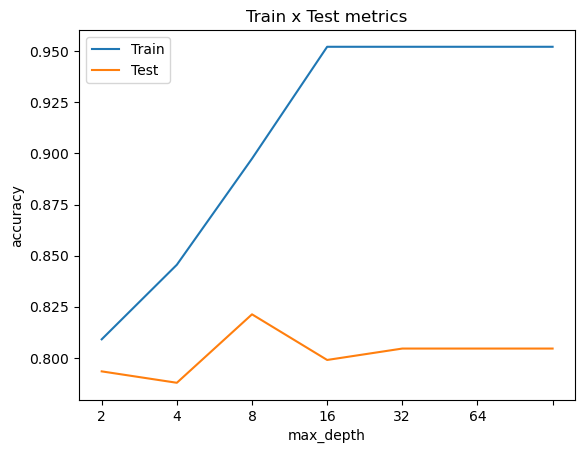

In [246]:
accuracy_list_train = []
accuracy_list_test = []
for max_depth in max_depth_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(max_depth = max_depth,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_test = model.predict(X_test) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_test = accuracy_score(predictions_test,y_test)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_test.append(accuracy_test)

plt.title('Train x Test metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_test)
plt.legend(['Train','Test'])

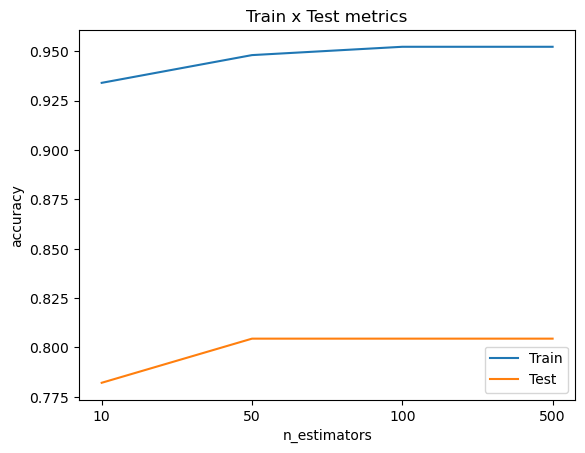

In [247]:
accuracy_list_train = []
accuracy_list_test = []
for n_estimators in n_estimators_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(n_estimators = n_estimators,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_test = model.predict(X_test) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_test = accuracy_score(predictions_test,y_test)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_test.append(accuracy_test)

plt.title('Train x Test metrics')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(n_estimators_list )),labels=n_estimators_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_test)
plt.legend(['Train','Test'])

Ajustons ensuite une forêt aléatoire avec les paramètres suivants :

 - profondeur_max : 8
 - min_samples_split : 300
 - n_estimateurs : 50

In [248]:
random_forest_model = RandomForestClassifier(n_estimators = 50,
                                             max_depth = 8, 
                                             min_samples_split = 300).fit(X_train,y_train)

In [249]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_test),y_test):.4f}")

Metrics train:
	Accuracy score: 0.7879
Metrics test:
	Accuracy score: 0.7821


## 4.3 XGBoost

Le dernier modele que  nous allons utiliser est le modèle Gradient Boosting, appelé XGBoost. Les méthodes de boosting entraînent plusieurs arbres, mais au lieu de les corréler les uns aux autres, les arbres sont désormais ajustés ultérieurement pour minimiser l'erreur.

Tout d’abord, définissons un sous-ensemble de notre ensemble de formation (nous ne devrions pas utiliser l’ensemble de test ici).

In [250]:
n = int(len(X_train)*0.8) ## Let's use 80% to train and 20% to eval

In [251]:
X_train_fit, X_train_eval, y_train_fit, y_train_eval = X_train[:n], X_train[n:], y_train[:n], y_train[n:]

Nous pouvons alors définir un grand nombre d'estimateurs, car vous pouvez vous arrêter si la fonction de coût cesse de diminuer.

In [252]:
xgb_model = XGBClassifier(n_estimators = 500, learning_rate = 0.1,verbosity = 1, random_state = RANDOM_STATE)
xgb_model.fit(X_train_fit,y_train_fit, eval_set = [(X_train_eval,y_train_eval)], early_stopping_rounds = 50)

[0]	validation_0-logloss:0.62360
[1]	validation_0-logloss:0.58678
[2]	validation_0-logloss:0.55619
[3]	validation_0-logloss:0.53140
[4]	validation_0-logloss:0.51006
[5]	validation_0-logloss:0.49351
[6]	validation_0-logloss:0.47821
[7]	validation_0-logloss:0.46509
[8]	validation_0-logloss:0.45455
[9]	validation_0-logloss:0.44448
[10]	validation_0-logloss:0.43472
[11]	validation_0-logloss:0.42954
[12]	validation_0-logloss:0.42306
[13]	validation_0-logloss:0.41958
[14]	validation_0-logloss:0.41519
[15]	validation_0-logloss:0.41205
[16]	validation_0-logloss:0.40957
[17]	validation_0-logloss:0.40768
[18]	validation_0-logloss:0.40547
[19]	validation_0-logloss:0.40392
[20]	validation_0-logloss:0.40463
[21]	validation_0-logloss:0.40528
[22]	validation_0-logloss:0.40383
[23]	validation_0-logloss:0.40466
[24]	validation_0-logloss:0.40449
[25]	validation_0-logloss:0.40531
[26]	validation_0-logloss:0.40593
[27]	validation_0-logloss:0.40487
[28]	validation_0-logloss:0.40481
[29]	validation_0-loglos

C:\Users\rsjas\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[65]	validation_0-logloss:0.42095
[66]	validation_0-logloss:0.42187
[67]	validation_0-logloss:0.42395
[68]	validation_0-logloss:0.42634
[69]	validation_0-logloss:0.42657
[70]	validation_0-logloss:0.42781
[71]	validation_0-logloss:0.42859
[72]	validation_0-logloss:0.42798


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=55, ...)

Comme vous pouvez le constater, même si vous avez réussi à ajuster 500 estimateurs, l'algorithme n'en a ajusté que 79 car la perte log utilisée pour métrifier les cycles de formation a commencé à augmenter. En fait, le nombre d'estimateurs est même inférieur à 79.

In [253]:
xgb_model.best_iteration

22

In [254]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_test),y_test):.4f}")

Metrics train:
	Accuracy score: 0.8680
Metrics test:
	Accuracy score: 0.8156


### Prédiction avec les données dans test

In [255]:
#Connaitre l'encodage du csv
with open('data/test.csv', 'rb') as file:
    rawdata = file.read(10000)
    result = chardet.detect(rawdata)
    enc = result['encoding']
#lire le csv
data = pd.read_csv('data/test.csv', encoding = enc)
#Afficher toutes les donnees
pd.set_option('display.max_rows', None)
select_id = data['PassengerId']

data = data.drop(columns=['Name','Ticket','PassengerId','Fare'])

# Utilisation de mask() pour remplacer toutes les valeurs non Nan par True
data['Cabin'] = data['Cabin'].mask(data['Cabin'].notna(),True)
#Remplacer toutes les valeurs Nan en False
data['Cabin'] = data['Cabin'].fillna(False)
data['Age'] = data['Age'].fillna(data_mean)
cat_variables = [
    'Sex','Embarked','Pclass'
]
data_hot = pd.get_dummies(data = data,
                         prefix = cat_variables,
                         columns = cat_variables)
data_hot.head()


,Age,SibSp,Parch,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,34.5,0,0,False,False,True,False,True,False,False,False,True
1,47.0,1,0,False,True,False,False,False,True,False,False,True
2,62.0,0,0,False,False,True,False,True,False,False,True,False
3,27.0,0,0,False,False,True,False,False,True,False,False,True
4,22.0,1,1,False,True,False,False,False,True,False,False,True


In [256]:
#print(X_train)
prediction = xgb_model.predict(data_hot)
print(prediction)

[0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0
 1 1 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 1 0 1 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 0 0 1 0 0 0]


### Écriture de la réponse dans un fichier csv

In [257]:
size = prediction.shape
data_csv = []
for i in range(size[0]):
    data_csv.append([select_id[i],prediction[i]])
header = ['PassengerId','Survived']
#Creer et ecrire dans le fichier csv
with open('data/predict_titanic.csv','w',newline='') as file:
    writer = csv.writer(file)
    #ecrire l'en-tete
    writer.writerow(header)
    #ecrire les donnees
    writer.writerows(data_csv)